In [1]:
import json
import glob

result = []
for f in glob.glob("EX11_articles/*.json"):
    with open(f, "rb") as infile:
        result.append(json.load(infile))

with open("merged_file.json", "wb") as outfile:
     json.dump(result, outfile)

In [2]:
import json

with open('merged_file.json') as data_file:    
    data = json.load(data_file)

t = []
for i in range(len(data)):
    for j in range(len(data[i])):
        if ('body' in data[i][j] and 'topics' in data[i][j]):
            t.append(data[i][j])

In [3]:
import numpy as np
import collections, re

print np.shape(t)

all_words = {}
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt['body'])) for txt in t]

(10377L,)


hashing the raw data to make a bag-of-words encoding of the body of 10377 articles. Remember to lower-case all words. This should result in a matrix, with one row for each article (which has a topic) and one column for each unique word in those articles.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1,lowercase=True)
Xh = vectorizer.fit_transform([(txt['body']) for txt in t])
Xh

<10377x28437 sparse matrix of type '<type 'numpy.float64'>'
	with 806834 stored elements in Compressed Sparse Row format>

Hash the articles to only 1000 features by using the modolo operation, so every single word will be allocated in a bucket within 32936, the matrix shape is  (10377L, 32936L)

In [7]:
import collections, re
all_words = {}
import mmh3
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt['body'])) for txt in t]
i = 0
for c in bagsofwords:
    for w in c.elements():
        if w not in all_words:
            all_words[w] = i
            i += 1
# fixed amount of features/buckets
print len(all_words)
print np.shape(bagsofwords)

words = ([(re.findall(r'\w+', txt['body'].lower())) for txt in t])
ah = np.zeros(( len(words),len(all_words)), dtype='int32')
for i in range(len(words)):
    for j, word in enumerate(words[i]):
        token = mmh3.hash(str(word)) % 1000
        ah[i, token] = 1
print np.shape(ah)

32936
(10377L,)


(10377L, 32936L)

Hash the articles to only 1000 features by using the modolo operation, so every single word will be allocated in a bucket within 1000, the matrix shape is  (10377L, 1000L)

In [6]:
import mmh3

words = ([(re.findall(r'\w+', txt['body'].lower())) for txt in t])
al = np.zeros(( len(words),1000), dtype='int32')
for i in range(len(words)):
    for j, word in enumerate(words[i]):
        token = mmh3.hash(str(word)) % 1000
        al[i, token] = 1
print np.shape(al)
al

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
X.toarray() 

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.05591611,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

The above vectorization scheme is simple but the fact that it holds an in- memory mapping from the string tokens to the integer feature indices (the vocabulary_ attribute) causes several problems when dealing with large datasets:
It is possible to overcome those limitations by combining the “hashing trick” (Feature hashing) implemented by the sklearn.feature_extraction.FeatureHasher class and the text preprocessing and tokenization features of the CountVectorizer. 

Now implement feature hashing and use 1000 buckets instead of the raw bag-of-words encoding. we see it has only 558568 stored elements,which is less than 806834 from the last hashing.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1,lowercase=True,max_features=1000)
Xl = vectorizer.fit_transform([(txt['body']) for txt in t])
Xl

<10377x1000 sparse matrix of type '<type 'numpy.float64'>'
	with 558568 stored elements in Compressed Sparse Row format>

In [10]:
#which article has 'earn' in the body text
Y = []
for i in range(len(bagsofwords)):
    if 'earn' in bagsofwords[i]:
        Y.append (1)
    else:
        Y.append(0)

In [11]:
# which article has 'earn'
C = []
for i in range(len(Y)):
    if Y[i] == 1:
        C.append(i)

In [12]:
# the real probability of all body text that contains 'earn' is 0.0047402535
from decimal import *
getcontext().prec = 10
r = (49./10337)
print C, len(C), "%.10f" %r

[485, 575, 597, 820, 834, 1010, 1041, 1130, 1601, 1847, 1927, 2043, 2291, 2341, 2347, 2388, 2400, 2736, 3014, 3186, 3442, 3933, 4013, 4131, 4470, 4565, 4795, 4798, 5155, 5946, 6062, 6130, 6287, 6472, 6762, 6782, 7376, 7429, 7605, 7745, 7868, 8386, 8678, 8684, 8882, 9206, 9441, 9585, 9588] 49 0.0047402535


Now we use two different sizes of buckets as threshold to test the performance of the random forest classifier,then visualize the result by a couple of receiver operating characteristic (ROC).

In [35]:
np.random.seed(10)
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, Y, test_size=0.2)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, Y, test_size=0.2)

# Supervised transformation based on random forests
rfl = RandomForestClassifier(max_depth=3,n_jobs=-1, n_estimators=50)
rfh = RandomForestClassifier(max_depth=3,n_jobs=-1, n_estimators=50)

rfl.fit(Xl_train, yl_train)
prel = rfl.predict(Xl_test)
# The random forest model by itself
yl_pred_rf = rfl.predict_proba(Xl_test)[:,1]
print "prediction_l: ", prel, "prediction of probability_l: ", yl_pred_rf
fpr_rf_l, tpr_rf_l, _ = roc_curve(yl_test, yl_pred_rf)

rfh.fit(Xh_train, yh_train)
preh = rfh.predict(Xh_test)

yh_pred_rf = rfh.predict_proba(Xh_test)[:,1]
print "prediction_h: ", preh, "prediction of probability_h: ", yh_pred_rf
fpr_rf_h, tpr_rf_h, _ = roc_curve(yh_test, yh_pred_rf)


prediction_l:  [0 0 0 ..., 0 0 0] prediction of probability_l:  [ 0.00261543  0.00248239  0.00464292 ...,  0.0240653   0.00248239
  0.00248239]
prediction_h:  [0 0 0 ..., 0 0 0] prediction of probability_h:  [ 0.00383222  0.00383222  0.00890477 ...,  0.00371144  0.00383222
  0.00383222]


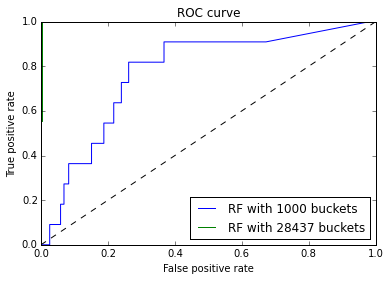

In [36]:
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_l, tpr_rf_l, label='RF with 1000 buckets')
plt.plot(fpr_rf_h, tpr_rf_h, label='RF with 28437 buckets')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

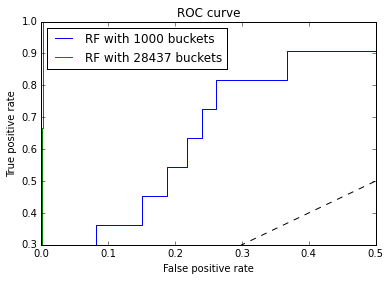

In [41]:
%matplotlib inline
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.3, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_l, tpr_rf_l, label='RF with 1000 buckets')
plt.plot(fpr_rf_h, tpr_rf_h, label='RF with 28437 buckets')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

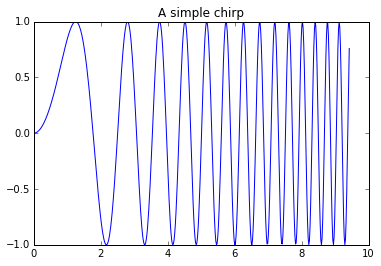

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp');

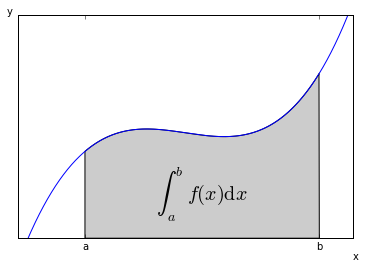

In [42]:
# %load http://matplotlib.sourceforge.net/mpl_examples/pylab_examples/integral_demo.py
#!/usr/bin/env python
%matplotlib inline
# implement the example graphs/integral from pyx
from pylab import *
from matplotlib.patches import Polygon

def func(x):
    return (x-3)*(x-5)*(x-7)+85

ax = subplot(111)

a, b = 2, 9 # integral area
x = arange(0, 10, 0.01)
y = func(x)
plot(x, y, linewidth=1)

# make the shaded region
ix = arange(a, b, 0.01)
iy = func(ix)
verts = [(a,0)] + list(zip(ix,iy)) + [(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)

text(0.5 * (a + b), 30,
     r"$\int_a^b f(x)\mathrm{d}x$", horizontalalignment='center',
     fontsize=20)

axis([0,10, 0, 180])
figtext(0.9, 0.05, 'x')
figtext(0.1, 0.9, 'y')
ax.set_xticks((a,b))
ax.set_xticklabels(('a','b'))
ax.set_yticks([])
show()
